In [ ]:
%reload_ext autoreload
%autoreload 2

# Supervised baselines

Notebook with strong supervised learning baseline on cifar-10

In [ ]:
!pip install -q wandb
!wandb login "your_key_here"

In [ ]:
from sssupervised.cifar_utils import CifarFactory
from fastai2.data.transforms import parent_label, Categorize

from fastai2.optimizer import ranger, Adam
from fastai2.layers import LabelSmoothingCrossEntropy
from fastai2.callback.all import *
from fastai2.callback.wandb import WandbCallback
from fastai2.metrics import error_rate

from fastai2.vision.augment import aug_transforms
from fastai2.vision.learner import cnn_learner
from fastai2.vision.models.xresnet import xresnet34

Simple but effective baseline strong augmentations, mixup, labelsmoothing, train for 100 epochs

In [ ]:
cifar = untar_data(URLs.CIFAR)
files, (train, test, unsup) = CifarFactory(n_same_cls=3, seed=42, n_labeled=400).splits_from_path(cifar)

sup_ds = Datasets(files, [[PILImage.create, ToTensor], [parent_label, Categorize]], splits=(train,test))
sup_dl = sup_ds.dataloaders(after_batch=[IntToFloatTensor, Normalize.from_stats(*cifar_stats)] + aug_transforms())

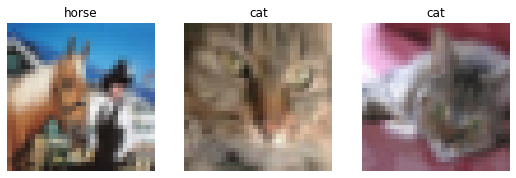

In [ ]:
sup_dl[0].show_batch(max_n=3)

In [ ]:
learner = cnn_learner(
    dls=sup_dl, 
    arch=xresnet34, 
    loss_func=LabelSmoothingCrossEntropy(),
    opt_func=Adam,
    metrics=error_rate,
    cbs=[ProgressCallback, MixUp, WandbCallback(log=None)],
    pretrained=False,
    normalize=False,
)

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle()